In [2]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from mtcnn.detector import detect_faces
from collections import OrderedDict

from models.pfld import PFLDInference, AuxiliaryNet

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/home/pervinco/PFLD-pytorch/checkpoint/snapshot/checkpoint.pth.tar'

In [4]:
def landmark_detection(img, det, model_path):
    checkpoint = torch.load(model_path, map_location=device)
    pfld_backbone = PFLDInference().to(device)
    pfld_backbone.load_state_dict(checkpoint['pfld_backbone'])
    pfld_backbone.eval()
    pfld_backbone = pfld_backbone.to(device)
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
     
    height, width = img.shape[:2] ## 원본 이미지 height, width
    x1, y1, x2, y2 = (det[:4] + 0.5).astype(np.int32) ## 바운딩 박스 좌표(정규화를 했었기 때문에 0.5를 더한다.)

    ## 바운딩 박스의 너비와 높이, 중심점을 계산.
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    cx = x1 + w // 2
    cy = y1 + h // 2

    ## 바운딩 박스 중심점을 기준으로 박스의 좌표를 다시 설정. 원래 크기의 1.1배로 조정함.
    size = int(max([w, h]) * 1.1)
    x1 = cx - size // 2
    x2 = x1 + size
    y1 = cy - size // 2
    y2 = y1 + size

    ## 사각형 영역이 이미지의 경계를 벗어나지 않도록 조정
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)

    ## 사각형 영역이 이미지 경계를 벗어난 경우를 처리하기 위해 추가 영역을 계산
    edx1 = max(0, -x1)
    edy1 = max(0, -y1)
    edx2 = max(0, x2 - width)
    edy2 = max(0, y2 - height)

    cropped = img[y1:y2, x1:x2]
    ## 경계를 벗어난 경우, 사각형 영역을 이미지 경계로 확장하여 패딩을 추가
    if (edx1 > 0 or edy1 > 0 or edx2 > 0 or edy2 > 0):
        cropped = cv2.copyMakeBorder(cropped, edy1, edy2, edx1, edx2, cv2.BORDER_CONSTANT, 0)

    input = cv2.resize(cropped, (112, 112))
    input = transform(input).unsqueeze(0).to(device)
    _, landmarks = pfld_backbone(input)
    pre_landmark = landmarks[0]

    ## 원래 이미지 크기로 스케일을 조정
    pre_landmark = pre_landmark.cpu().detach().numpy().reshape(-1, 2) * [size, size] - [edx1, edy1]
    
    result = []
    for p in pre_landmark:
        x = p[0] + x1 
        y = p[1] + y1
        result.append([int(x), int(y)])

    return result

In [5]:
def calc_gr(pts, bounding_boxes, n =4):
    result = []
    A = pts[64][1] - pts[76][1]
    B = pts[76][1] - pts[16][1]
    
    result.append(round(A/B,n))
    
    A = bounding_boxes[1] - pts[59][1]
    B = pts[59][1] - pts[16][1]
    
    result.append(round(A/B,n))
    
    A = pts[64][0] - pts[0][0]
    B = pts[68][0] - pts[64][0]
    
    result.append(round(A/B,n))
    A = pts[32][0] - pts[68][0]
    B = pts[68][0] - pts[64][0]
    
    result.append(round(A/B,n))
    
    return result, sum(result)/len(result)

황금비 결과 리스트 : [1.3733, 1.783, 1.6481, 1.6111], 황금비 결과 평균값 : 1.604


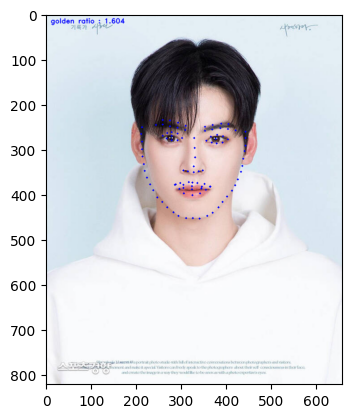

In [6]:
test_img_path = './sample.jpeg'
test_img = cv2.imread(test_img_path)
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

bounding_boxes, _ = detect_faces(test_img_gray) # bounding boxes : [x1. y1. x2. y2, confidence]
landmark = landmark_detection(test_img, bounding_boxes[0][:4] , model_path)

for p in landmark:
    cv2.circle(test_img, (p[0], p[1]), 2, (255, 0, 0), -1)



result_list, result = calc_gr(landmark,bounding_boxes[0][:4])
cv2.putText(test_img, "golden ratio : " + str(round(result, 3)), (10,20),cv2.FONT_HERSHEY_DUPLEX, 0.5,(255,0,0), thickness=1, lineType=cv2.LINE_AA)
cv2.imwrite("../result.png", test_img)
print(f"황금비 결과 리스트 : {result_list}, 황금비 결과 평균값 : {result:.3f}")

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()